In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

print("Train Data Head:")
print(train_data.head())

Train Data Head:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   

In [3]:
# train과 test 데이터셋을 함께 처리하기 위해 잠시 결합 (전처리 일관성 유지)
data = [train_data, test_data]
# 'Cabin'은 새로운 특징 생성에 사용되지 않으므로, 먼저 처리할 필요 없음.
# 'Ticket' 역시 바로 제거

# 1. 이름(Name)에서 'title' 특징을 만들기 위해 먼저 추출
for dataset in data:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

In [4]:
# 2. Age (나이) 결측치 채우기: Title별 중앙값 사용
for dataset in data:
    # 널 값 채우기 (fillna)
    median_age = dataset.groupby('Title')['Age'].transform('median')
    dataset['Age'] = dataset['Age'].fillna(median_age)

# 3. Fare (운임) 결측치 채우기: 중앙값 사용
test_data['Fare'] = test_data['Fare'].fillna(test_data['Fare'].median())

# 4. Embarked (탑승지) 결측치 채우기: 최빈값 'S' 사용
train_data['Embarked'] = train_data['Embarked'].fillna('S')

In [5]:
# 1. Title 특징 정규화 및 매핑
for dataset in data:
    # 잦지 않은 Title을 Other로 통합
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Other')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

    # 문자열 Title을 숫자로 매핑 (이미지 2의 title 0, 1, 2, 3)
    title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, "Master": 3, "Other": 4}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(4) # 혹시 남은 결측치 처리

In [6]:
# 2. family_num 특징 생성
for dataset in data:
    dataset['family_num'] = dataset['SibSp'] + dataset['Parch']

# 3. alone 특징 생성
for dataset in data:
    dataset['alone'] = np.where(dataset['family_num'] == 0, 1.0, 0.0)

In [7]:
# 4. Sex(성별)와 Embarked(탑승지)를 숫자로 매핑
sex_mapping = {"female": 0, "male": 1}
embarked_mapping = {'S': 0, 'C': 1, 'Q': 2}

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(sex_mapping)
    dataset['Embarked'] = dataset['Embarked'].map(embarked_mapping)

# 5. 최종 특징 제거 (이미지 2와 유사하게 정리)
features_to_drop = ['Name','Ticket', 'Cabin', 'PassengerId']

train_data = train_data.drop(features_to_drop, axis=1, errors='ignore')
test_data = test_data.drop(features_to_drop, axis=1, errors='ignore')

In [8]:
print("--- Train Data Info (최종 특징 목록 및 타입) ---")
# Train Data의 최종 컬럼 목록과 데이터 타입을 확인합니다.
train_data.info()

print("\n--- Test Data Info (최종 특징 목록 및 타입) ---")
# Test Data의 최종 컬럼 목록과 데이터 타입을 확인합니다.
test_data.info()

print("\n--- Train Data 상위 5개 행 (정제 및 특징 생성 결과) ---")
# 데이터의 상위 5개 행을 출력하여 새로 생성된 특징(title, family_num, alone)과 
# 유지된 SibSp, Parch를 시각적으로 확인합니다.
print(train_data.head())

print("\n--- 최종 특징 개수 ---")
# 최종 특징 개수를 확인합니다.
print(f"Train Data Features Count: {train_data.shape[1]}") # Survived(타겟) 포함
print(f"Test Data Features Count: {test_data.shape[1]}")  # Survived(타겟) 미포함

--- Train Data Info (최종 특징 목록 및 타입) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    int64  
 3   Age         891 non-null    float64
 4   SibSp       891 non-null    int64  
 5   Parch       891 non-null    int64  
 6   Fare        891 non-null    float64
 7   Embarked    891 non-null    int64  
 8   Title       891 non-null    int64  
 9   family_num  891 non-null    int64  
 10  alone       891 non-null    float64
dtypes: float64(3), int64(8)
memory usage: 76.7 KB

--- Test Data Info (최종 특징 목록 및 타입) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      418 non-null    int64  
 1 

In [9]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
# 출력 폭 제한을 해제 (무제한)
pd.set_option("display.width", None)
# 모든 컬럼 출력되도록 설정
pd.set_option("display.max_columns", None)

class TitanicDataset(Dataset):
  def __init__(self, X, y):
    self.X = torch.FloatTensor(X)
    self.y = torch.LongTensor(y)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    feature = self.X[idx]
    target = self.y[idx]
    return {'input': feature, 'target': target}

  def __str__(self):
    str = "Data Size: {0}, Input Shape: {1}, Target Shape: {2}".format(
      len(self.X), self.X.shape, self.y.shape
    )
    return str


class TitanicTestDataset(Dataset):
  def __init__(self, X):
    self.X = torch.FloatTensor(X)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    feature = self.X[idx]
    return {'input': feature}

  def __str__(self):
    str = "Data Size: {0}, Input Shape: {1}".format(
      len(self.X), self.X.shape
    )
    return str


def get_preprocessed_dataset():
    DATA_ROOT = "/kaggle/input/titanic"

    train_data_path = os.path.join(DATA_ROOT, "train.csv")
    test_data_path = os.path.join(DATA_ROOT, "test.csv")

    train_df = pd.read_csv(train_data_path)
    test_df = pd.read_csv(test_data_path)

    all_df = pd.concat([train_df, test_df], sort=False)

    all_df = get_preprocessed_dataset_1(all_df)

    all_df = get_preprocessed_dataset_2(all_df)

    all_df = get_preprocessed_dataset_3(all_df)

    all_df = get_preprocessed_dataset_4(all_df)

    all_df = get_preprocessed_dataset_5(all_df)

    all_df = get_preprocessed_dataset_6(all_df)
    print("\n--- 전처리 후 남은 결측치 (NaN) 개수 ---")
    print(all_df.isnull().sum())

    print(all_df.columns)
    print(all_df.head(10))

    train_X = all_df[~all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)
    train_y = train_df["Survived"]

    test_X = all_df[all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)
    dataset = TitanicDataset(train_X.values, train_y.values)
    print(dataset)

    train_dataset, validation_dataset = random_split(dataset, [0.8, 0.2])
    test_dataset = TitanicTestDataset(test_X.values)
    #print(test_dataset)

    return train_dataset, validation_dataset, test_dataset


def get_preprocessed_dataset_1(all_df):
    # Pclass별 Fare (요금) 평균값을 사용하여 Fare 결측치 메우기
    Fare_mean = all_df[["Pclass", "Fare"]].groupby("Pclass").mean().reset_index()
    Fare_mean.columns = ["Pclass", "Fare_mean"]
    all_df = pd.merge(all_df, Fare_mean, on="Pclass", how="left")
    all_df.loc[(all_df["Fare"].isnull()), "Fare"] = all_df["Fare_mean"]
    all_df = all_df.drop(columns=["Fare_mean"])

    return all_df


def get_preprocessed_dataset_2(all_df):
    # name을 세 개의 컬럼으로 분리하여 다시 all_df에 합침
    name_df = all_df["Name"].str.split("[,.]", n=2, expand=True)
    name_df.columns = ["family_name", "title", "name"]
    name_df["family_name"] = name_df["family_name"].str.strip()
    name_df["title"] = name_df["title"].str.strip()
    name_df["name"] = name_df["name"].str.strip()
    all_df = pd.concat([all_df, name_df], axis=1)

    return all_df


def get_preprocessed_dataset_3(all_df):
    # title별 Age 평균값을 사용하여 Age 결측치 메우기
    title_age_mean = all_df[["title", "Age"]].groupby("title").median().round().reset_index()
    title_age_mean.columns = ["title", "title_age_mean", ]
    all_df = pd.merge(all_df, title_age_mean, on="title", how="left")
    all_df.loc[(all_df["Age"].isnull()), "Age"] = all_df["title_age_mean"]
    all_df = all_df.drop(["title_age_mean"], axis=1)

    return all_df


def get_preprocessed_dataset_4(all_df):
    # 가족수(family_num) 컬럼 새롭게 추가
    all_df["family_num"] = all_df["Parch"] + all_df["SibSp"]

    # 혼자탑승(alone) 컬럼 새롭게 추가
    all_df.loc[all_df["family_num"] == 0, "alone"] = 1
    all_df["alone"].fillna(0)

    # 학습에 불필요한 컬럼 제거
    all_df = all_df.drop(["PassengerId", "Name", "family_name", "name", "Ticket", "Cabin"], axis=1)

    return all_df


def get_preprocessed_dataset_5(all_df):
    # title 값 개수 줄이기
    all_df.loc[
    ~(
            (all_df["title"] == "Mr") |
            (all_df["title"] == "Miss") |
            (all_df["title"] == "Mrs") |
            (all_df["title"] == "Master")
    ),
    "title"
    ] = "other"
    all_df["Embarked"].fillna("missing")

    return all_df


def get_preprocessed_dataset_6(all_df):
    # 카테고리 변수를 LabelEncoder를 사용하여 수치값으로 변경하기
    category_features = all_df.columns[all_df.dtypes == "object"]
    from sklearn.preprocessing import LabelEncoder
    for category_feature in category_features:
        le = LabelEncoder()
        if all_df[category_feature].dtypes == "object":
          le = le.fit(all_df[category_feature])
          all_df[category_feature] = le.transform(all_df[category_feature])

    return all_df

if __name__ == "__main__":
  train_dataset, validation_dataset, test_dataset = get_preprocessed_dataset()

  print("train_dataset: {0}, validation_dataset.shape: {1}, test_dataset: {2}".format(
    len(train_dataset), len(validation_dataset), len(test_dataset)
  ))
  print("#" * 50, 1)

  train_data_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
  validation_data_loader = DataLoader(dataset=validation_dataset, batch_size=len(validation_dataset), shuffle=True)
  test_data_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset))

  print("[TRAIN]")
  for idx, batch in enumerate(train_data_loader):
    print("{0} - {1}: {2}".format(idx, batch['input'].shape, batch['target'].shape))

  print("[VALIDATION]")
  for idx, batch in enumerate(validation_data_loader):
    print("{0} - {1}: {2}".format(idx, batch['input'].shape, batch['target'].shape))

  print("[TEST]")
  for idx, batch in enumerate(test_data_loader):
    print("{0} - {1}".format(idx, batch['input'].shape))




--- 전처리 후 남은 결측치 (NaN) 개수 ---
Survived      418
Pclass          0
Sex             0
Age             0
SibSp           0
Parch           0
Fare            0
Embarked        0
title           0
family_num      0
alone         519
dtype: int64
Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'title', 'family_num', 'alone'],
      dtype='object')
   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  title  \
0       0.0       3    1  22.0      1      0   7.2500         2      2   
1       1.0       1    0  38.0      1      0  71.2833         0      3   
2       1.0       3    0  26.0      0      0   7.9250         2      1   
3       1.0       1    0  35.0      1      0  53.1000         2      3   
4       0.0       3    1  35.0      0      0   8.0500         2      2   
5       0.0       3    1  29.0      0      0   8.4583         1      2   
6       0.0       1    1  54.0      0      0  51.8625         2      2   
7       0.0       3    

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [10]:
pip install wandb

Note: you may need to restart the kernel to use updated packages.


In [11]:
# Cell 1: 라이브러리 임포트

import os
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import copy
import sys
import wandb
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f"Global seed set to {seed}")

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [12]:
# Cell 2: 기본 설정 및 하이퍼파라미터 (실험을 위해 이 부분을 수정합니다)

USE_WANDB = False

# 데이터 경로
DATA_PATH = "/kaggle/input/titanic/"
TRAIN_CSV_PATH = os.path.join(DATA_PATH, "train.csv")
TEST_CSV_PATH = os.path.join(DATA_PATH, "test.csv")

# 활성화 함수 매핑
ACTIVATION_FUNCTIONS = {
    "LeakyReLU": nn.LeakyReLU
}

# 하이퍼파라미터
CONFIG = {
    'epochs': 1000,
    'batch_size': 32,     
    'learning_rate': 1e-4,
    'n_hidden_unit_list': [20, 20],
    'activation': 'LeakyReLU',
    'seed': 42
}

set_seed(CONFIG['seed'])

Global seed set to 42


In [13]:
# Cell 3: 데이터 전처리 함수 정의

def get_preprocessed_dataset_1(all_df):
    Fare_mean = all_df[["Pclass", "Fare"]].groupby("Pclass").mean().reset_index()
    Fare_mean.columns = ["Pclass", "Fare_mean"]
    all_df = pd.merge(all_df, Fare_mean, on="Pclass", how="left")
    all_df.loc[(all_df["Fare"].isnull()), "Fare"] = all_df["Fare_mean"]
    all_df = all_df.drop(columns=["Fare_mean"])
    return all_df

def get_preprocessed_dataset_2(all_df):
    name_df = all_df["Name"].str.split("[,.]", n=2, expand=True)
    name_df.columns = ["family_name", "title", "name"]
    name_df["family_name"] = name_df["family_name"].str.strip()
    name_df["title"] = name_df["title"].str.strip()
    name_df["name"] = name_df["name"].str.strip()
    all_df = pd.concat([all_df, name_df], axis=1)
    return all_df

def get_preprocessed_dataset_3(all_df):
    title_age_median = all_df[["title", "Age"]].groupby("title").median().round().reset_index()
    title_age_median.columns = ["title", "title_age_median"]
    all_df = pd.merge(all_df, title_age_median, on="title", how="left")
    all_df.loc[(all_df["Age"].isnull()), "Age"] = all_df["title_age_median"]
    all_df = all_df.drop(["title_age_median"], axis=1)
    return all_df

def get_preprocessed_dataset_4(all_df):
    all_df["family_num"] = all_df["Parch"] + all_df["SibSp"]
    all_df.loc[all_df["family_num"] == 0, "alone"] = 1
    all_df["alone"] = all_df["alone"].fillna(0)
    all_df = all_df.drop(["PassengerId", "Name", "family_name", "name", "Ticket", "Cabin"], axis=1)
    return all_df

def get_preprocessed_dataset_5(all_df):
    all_df.loc[
        ~((all_df["title"] == "Mr") | (all_df["title"] == "Miss") | (all_df["title"] == "Mrs") | (all_df["title"] == "Master")),
        "title"
    ] = "other"
    embarked_mode = all_df['Embarked'].mode()[0]
    all_df["Embarked"] = all_df["Embarked"].fillna(embarked_mode)
    return all_df

def get_preprocessed_dataset_6(all_df):
    category_features = all_df.columns[all_df.dtypes == "object"]
    for category_feature in category_features:
        le = LabelEncoder()
        if all_df[category_feature].dtypes == "object":
            le = le.fit(all_df[category_feature])
            all_df[category_feature] = le.transform(all_df[category_feature])
    return all_df


In [14]:
# Cell 4: 데이터 로딩 및 전처리 실행

train_df = pd.read_csv(TRAIN_CSV_PATH)
test_df = pd.read_csv(TEST_CSV_PATH)
submission_df = pd.read_csv(os.path.join(DATA_PATH, "gender_submission.csv"))
all_df = pd.concat([train_df, test_df], sort=False)
all_df = get_preprocessed_dataset_1(all_df)
all_df = get_preprocessed_dataset_2(all_df)
all_df = get_preprocessed_dataset_3(all_df)
all_df = get_preprocessed_dataset_4(all_df)
all_df = get_preprocessed_dataset_5(all_df)
all_df = get_preprocessed_dataset_6(all_df)
train_X = all_df[~all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)
train_y = train_df["Survived"]
test_X = all_df[all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)

In [15]:
# Cell 5: PyTorch Dataset 및 DataLoader 정의

class TitanicDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return {'input': self.X[idx], 'target': self.y[idx]}

class TitanicTestDataset(Dataset):
    def __init__(self, X):
        self.X = torch.FloatTensor(X)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return {'input': self.X[idx]}

full_dataset = TitanicDataset(train_X.values, train_y.values)
train_size = int(0.8 * len(full_dataset))
validation_size = len(full_dataset) - train_size
train_dataset, validation_dataset = random_split(full_dataset, [train_size, validation_size])
test_dataset = TitanicTestDataset(test_X.values)
train_data_loader = DataLoader(dataset=train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
validation_data_loader = DataLoader(dataset=validation_dataset, batch_size=len(validation_dataset))
test_data_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset))


In [16]:
# Cell 6: 유연한 모델 클래스 정의

class MyModel(nn.Module):
    def __init__(self, n_input, n_output, activation_fn):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n_input, CONFIG['n_hidden_unit_list'][0]),
            activation_fn(),
            nn.Linear(CONFIG['n_hidden_unit_list'][0], CONFIG['n_hidden_unit_list'][1]),
            activation_fn(),
            nn.Linear(CONFIG['n_hidden_unit_list'][1], n_output),
        )
    def forward(self, x):
        return self.model(x)


In [17]:
# Cell 7: 모델 체크포인팅 기능이 추가된 학습 루프 함수 정의

def training_loop(model, optimizer, train_loader, val_loader, loss_fn, epochs, device):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # 가장 좋았던 시점의 성능과 모델 상태를 저장할 변수
    best_accuracy = 0.0
    best_model_state = None

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            inputs, targets = batch['input'].to(device), batch['target'].to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs.squeeze(), targets.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        correct_preds = 0
        total_samples = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs, targets = batch['input'].to(device), batch['target'].to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs.squeeze(), targets.float())
                val_loss += loss.item()
                preds = torch.sigmoid(outputs.squeeze()) > 0.5
                total_samples += targets.size(0)
                correct_preds += (preds == targets.bool()).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        accuracy = correct_preds / total_samples

        # 모델 체크포인팅 로직
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model_state = copy.deepcopy(model.state_dict())
            best_epoch = epoch
            

  

        if USE_WANDB:
            wandb.log({
                "Epoch": epoch,
                "Training loss": avg_train_loss,
                "Validation loss": avg_val_loss,
                "Accuracy": accuracy
            })
        
        if epoch % 100 == 0 or epoch == epochs:
            print(f"Epoch {epoch}/{epochs}, Acc: {accuracy:.4f} (Best Acc: {best_accuracy:.4f}), Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
            sys.stdout.flush()
    print(f"\nBest validation accuracy: {best_accuracy:.4f}, Epoch: {best_epoch}")
    return best_model_state, best_epoch


In [18]:
# Cell 8:모델 학습 실행 (단일 최적 조건으로만 실행)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# CONFIG에서 설정된 단일 조건만 사용
act_name = CONFIG['activation']
act_class = ACTIVATION_FUNCTIONS[act_name]
exp_name = f"batch_{CONFIG['batch_size']}_act_{act_name}"
    

print("\n" + "=" * 60)
print(f"Starting Final Experiment: {exp_name} ---")
print(f"Using device: {device}")
print(f"Current Experiment Config: {CONFIG}")
print("=" * 60)

# 1. WandB 런 시작
if USE_WANDB:
    try:
        # 단일 Run이므로 finish_previous/reinit 없이 깔끔하게 초기화
        wandb.init(
            project="titanic-survival-prediction-kaggle",
            config=CONFIG,
            name=exp_name
        )
    except Exception as e:
        print(f"W&B 초기화 실패. 오류: {e}")
        wandb.init(mode="disabled")

# 2. 모델, 옵티마이저, 손실 함수 초기화
model = MyModel(
    n_input=train_X.shape[1],
    n_output=1,
    activation_fn=act_class 
)
optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])
loss_fn = nn.BCEWithLogitsLoss()

# 3. training_loop 실행 (최고 모델 상태를 반환받음)
best_model_state, best_epoch = training_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_data_loader,
    val_loader=validation_data_loader,
    loss_fn=loss_fn,
    epochs=CONFIG['epochs'],
    device=device
)

# 4. WandB 런 종료
if USE_WANDB:
    wandb.finish()

print(f"최종 훈련 완료: {exp_name} 모델 훈련 완료!")

Using device: cpu

Starting Final Experiment: batch_32_act_LeakyReLU ---
Using device: cpu
Current Experiment Config: {'epochs': 1000, 'batch_size': 32, 'learning_rate': 0.0001, 'n_hidden_unit_list': [20, 20], 'activation': 'LeakyReLU', 'seed': 42}
Epoch 100/1000, Acc: 0.7095 (Best Acc: 0.7095), Train Loss: 0.5656, Val Loss: 0.5672
Epoch 200/1000, Acc: 0.7151 (Best Acc: 0.7318), Train Loss: 0.5362, Val Loss: 0.5279
Epoch 300/1000, Acc: 0.7877 (Best Acc: 0.7877), Train Loss: 0.4918, Val Loss: 0.4842
Epoch 400/1000, Acc: 0.8045 (Best Acc: 0.8156), Train Loss: 0.4572, Val Loss: 0.4579
Epoch 500/1000, Acc: 0.8156 (Best Acc: 0.8212), Train Loss: 0.4448, Val Loss: 0.4413
Epoch 600/1000, Acc: 0.8156 (Best Acc: 0.8324), Train Loss: 0.4233, Val Loss: 0.4336
Epoch 700/1000, Acc: 0.8212 (Best Acc: 0.8436), Train Loss: 0.4164, Val Loss: 0.4259
Epoch 800/1000, Acc: 0.8268 (Best Acc: 0.8547), Train Loss: 0.4122, Val Loss: 0.4209
Epoch 900/1000, Acc: 0.8436 (Best Acc: 0.8547), Train Loss: 0.4024, Val

In [19]:
# Cell 9:최적 모델 (단일 실험 결과)로 제출 파일 생성

print(f"사용한 모델 :  '{act_name}', Batch Size {CONFIG['batch_size']}.")

final_model = model 

if best_model_state:
    model.load_state_dict(best_model_state)
    print(f"\n{best_epoch} 에포크의 최적 모델이 로드되었습니다.")
else:
    print("\n최적 모델 상태가 명시적으로 저장되지 않아, 최종 에포크 모델을 사용합니다.")


final_model.eval()
predictions = []
with torch.no_grad():
    for batch in test_data_loader:
        inputs = batch['input'].to(device) 
        outputs = final_model(inputs)
        preds = (torch.sigmoid(outputs.squeeze()) > 0.5).int()
        
        if preds.ndim == 0:
            preds = preds.unsqueeze(0)
        predictions.extend(preds.cpu().numpy())

submission_df['Survived'] = predictions
submission_df.to_csv('submission.csv', index=False)

print("\n'submission.csv' 파일이 생성되었습니다.")
print(submission_df.head())

사용한 모델 :  'LeakyReLU', Batch Size 32.

763 에포크의 최적 모델이 로드되었습니다.

'submission.csv' 파일이 생성되었습니다.
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0


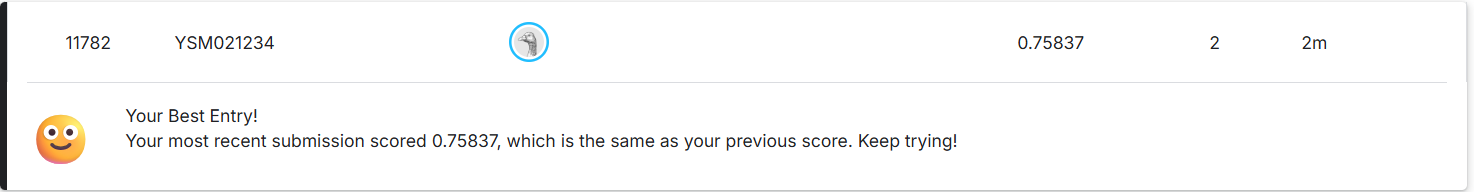